# Amsterdam Airbnb Data

In [1]:
import pathlib
import pickle
import pandas as pd
import seaborn as sns

import utils

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

In [2]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
processed_file_path = DATA_DIR / 'processed' / 'data_amsterdam.pkl'

with open(processed_file_path, 'rb') as file:
    (
        data,
        continuous_variables,
        discrete_variables,
        ordinal_variables,
        categorical_variables,
    ) = pickle.load(file)

In [3]:
data.head()

,City,Price,Day,Room Type,Shared Room,Private Room,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,Bedrooms,City Center (km),Metro Distance (km),Attraction Index,Restraunt Index,LogPrice,Price_per_GDP,LogPrice_per_GDP
0,Amsterdam,194.033698,Weekday,Private room,False,True,2.0,False,1.0,0.0,10,93,1.0,5.022964,2.539380,78.690379,98.253896,2.287877,0.003359,-2.473809
1,Amsterdam,344.245776,Weekday,Private room,False,True,4.0,False,0.0,0.0,8,85,1.0,0.488389,0.239404,631.176378,837.280757,2.536869,0.005959,-2.224818
2,Amsterdam,264.101422,Weekday,Private room,False,True,2.0,False,0.0,1.0,9,87,1.0,5.748312,3.651621,75.275877,95.386955,2.421771,0.004572,-2.339916
3,Amsterdam,433.529398,Weekday,Private room,False,True,4.0,False,0.0,1.0,9,90,2.0,0.384862,0.439876,493.272534,875.033098,2.637019,0.007505,-2.124668
4,Amsterdam,485.552926,Weekday,Private room,False,True,2.0,True,0.0,0.0,10,98,1.0,0.544738,0.318693,552.830324,815.305740,2.686237,0.008405,-2.075450


##### Treating Price Outliers 

<Axes: xlabel='LogPrice', ylabel='Density'>

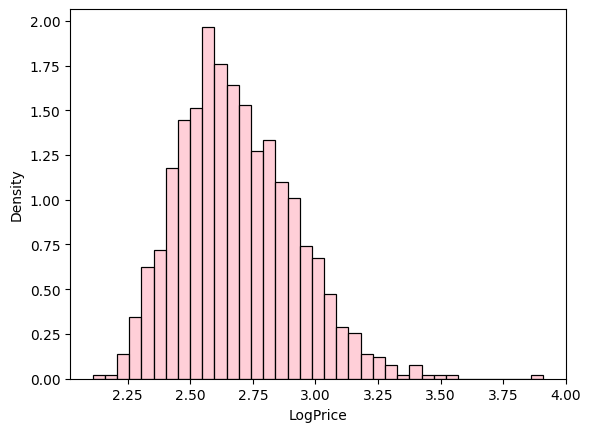

In [4]:
sns.histplot(data['LogPrice'], color = 'pink', stat="density")

In [5]:
q1=data['LogPrice'].quantile(.25)
q2=data['LogPrice'].quantile(.50)
q3=data['LogPrice'].quantile(.75)
iqr=q3-q1
print('first quartile is %.1f'%q1)
print('second quartile is %.1f'%q2)
print('third quartile is %.1f'%q3)
print('interquartile range is %.1f'%iqr)

limit_low=q1-iqr*1.999
limit_high=q3+iqr*1.999
print('lower limit is %.1f'%limit_low)
print('upper limit is %.1f'%limit_high)

first quartile is 2.5
second quartile is 2.7
third quartile is 2.8
interquartile range is 0.3
lower limit is 1.9
upper limit is 3.5


In [6]:
data = data[data['LogPrice'] < limit_high].copy()

<Axes: xlabel='LogPrice', ylabel='Count'>

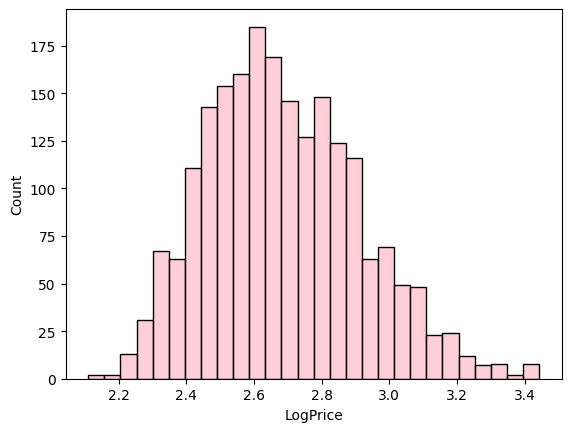

In [7]:
sns.histplot(data['LogPrice'], color = 'pink')

Limpando variaveis categoricas que não serão usadas nesta análise

In [8]:
cat_variables = categorical_variables
cat_variables.remove('City')

             count unique              top  freq
Day           2074      2          Weekday  1100
Room Type     2074      3  Entire home/apt  1120
Shared Room   2074      2            False  2064
Private Room  2074      2            False  1130
Superhost     2074      2            False  1483


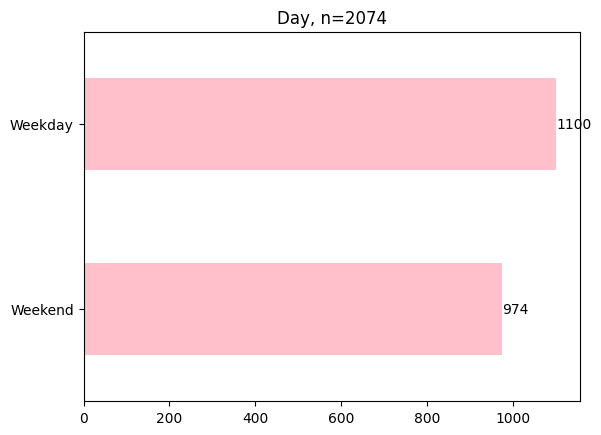

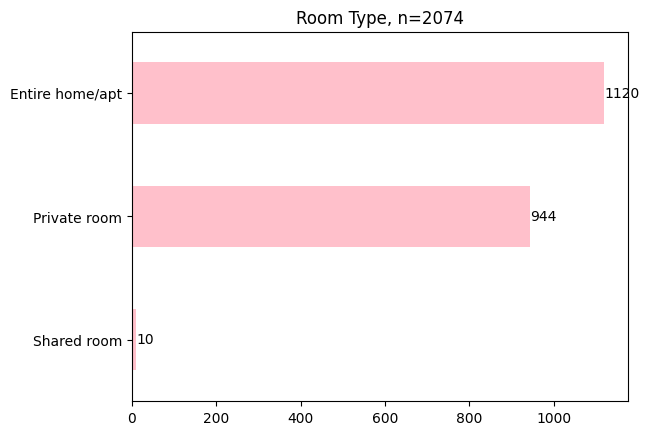

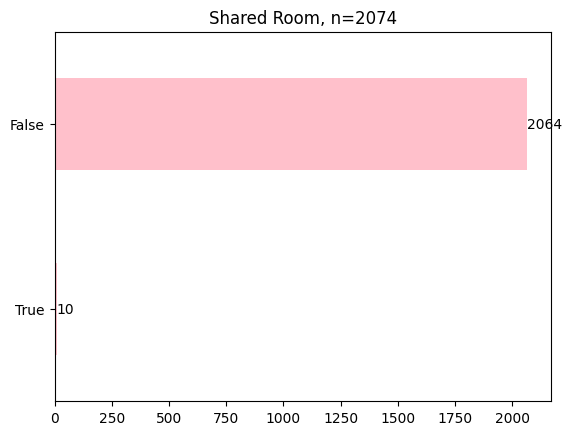

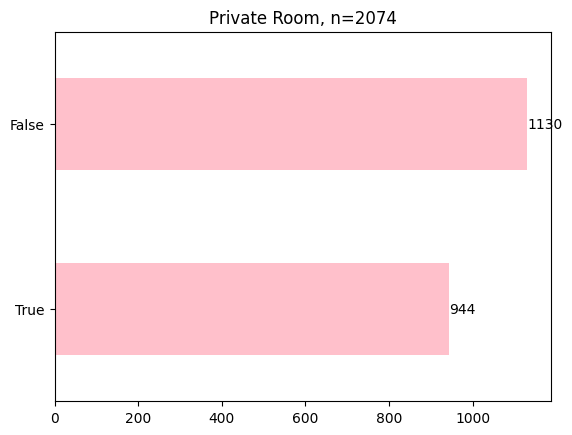

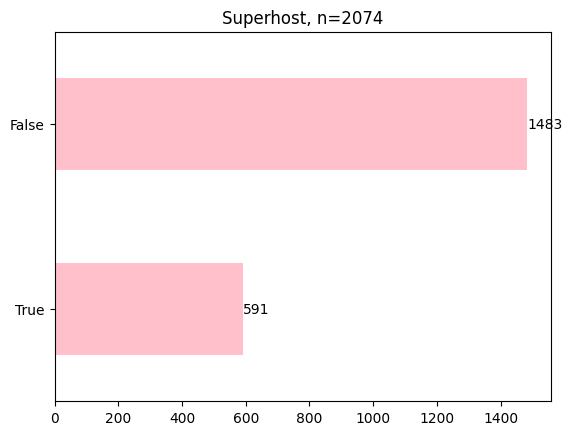

In [9]:
utils.plot_categoricals(data, cat_variables)

OBS: Quase não temos dados para shared rooms

DECISÃO: Remover airbnb que são do tipo shared rooms

In [10]:
data = data[data['Room Type'] != 'Shared room'].copy()
data.drop(columns = ['Shared Room'], inplace = True)

                  count      mean       std  min  25%  50%  75%  max
Person Capacity  2064.0  2.775678  1.028706  2.0  2.0  2.0  4.0  6.0
Multiple Rooms   2064.0  0.281492  0.449836  0.0  0.0  0.0  1.0  1.0
Business         2064.0  0.106105  0.308046  0.0  0.0  0.0  0.0  1.0
Bedrooms         2064.0  1.287791  0.730557  0.0  1.0  1.0  2.0  5.0


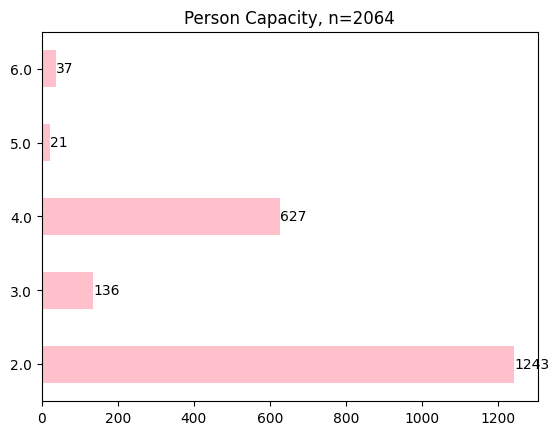

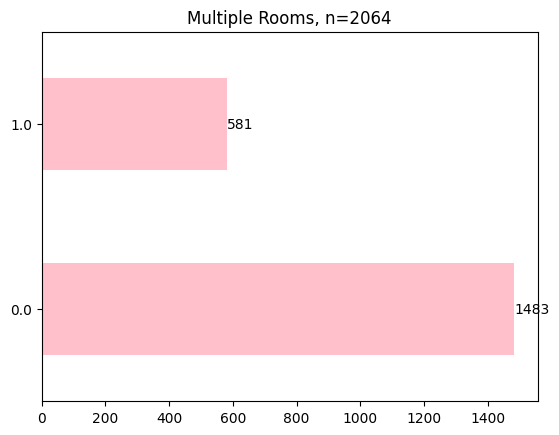

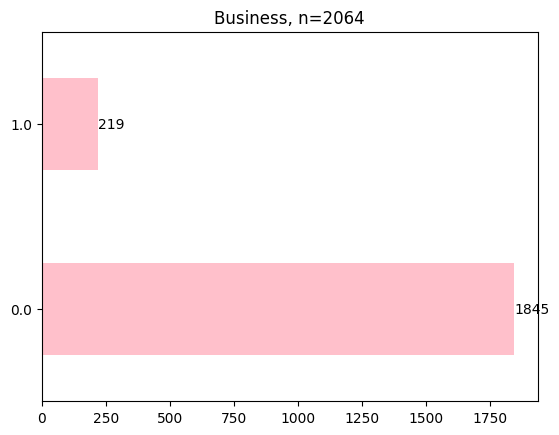

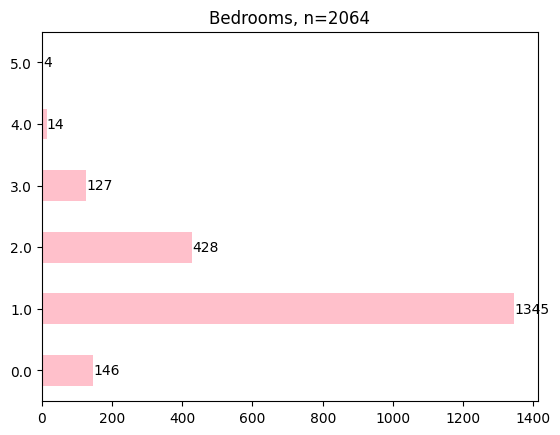

In [11]:
utils.plot_discretes(data, discrete_variables, sorted=False)

Limpando variaveis continuas que não serão usadas nesta análise

In [12]:
cat_continuous = continuous_variables
cat_continuous.remove('Normalised Attraction Index')
cat_continuous.remove('Normalised Restraunt Index')

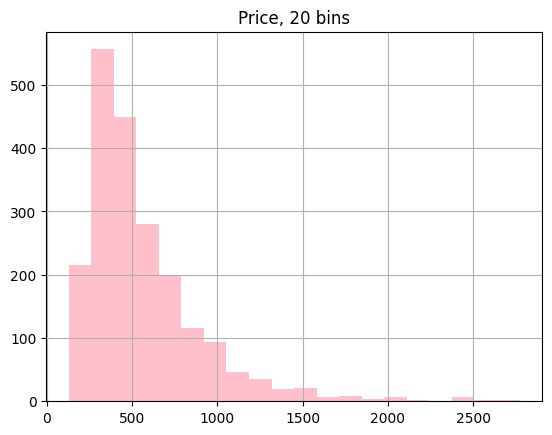

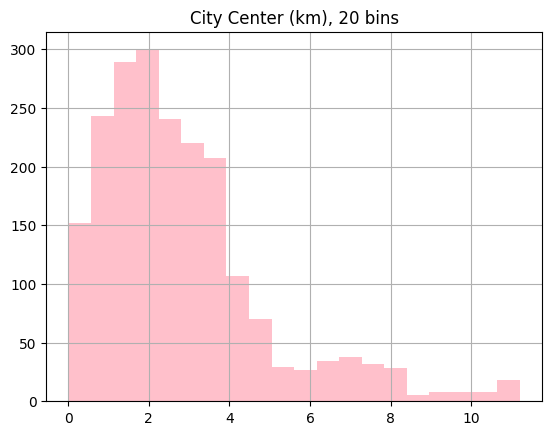

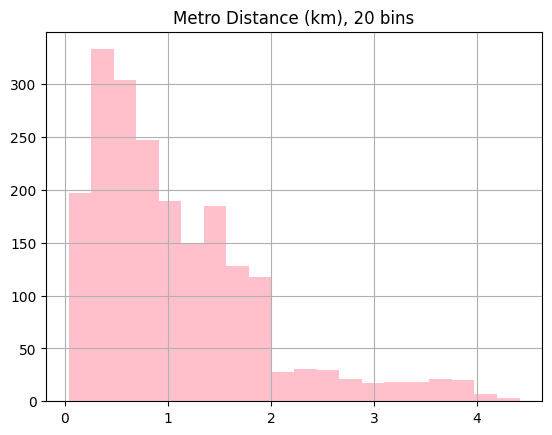

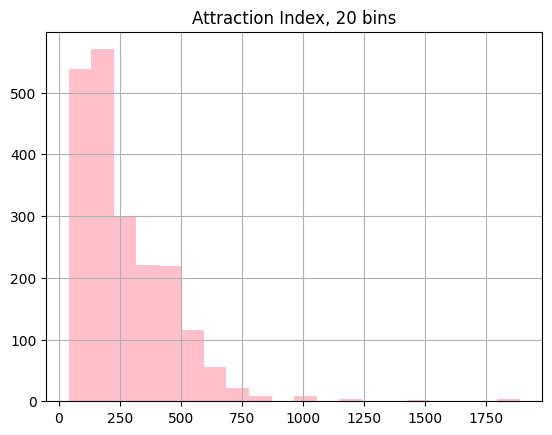

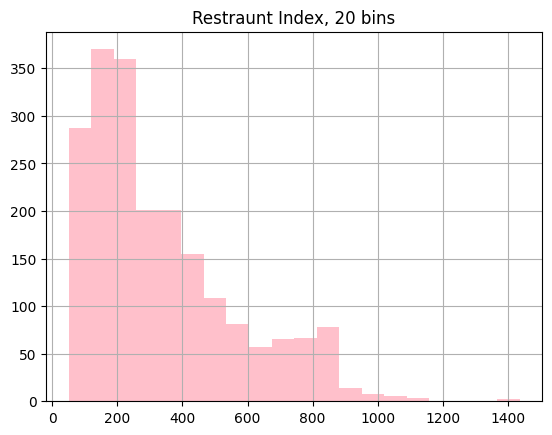

In [13]:
utils.plot_continuous(data, cat_continuous)

Vamos analisar dois tipos de airbnb separadamente, entire home/apt e private room, em buscada de identificar caracteristicas que influenciam o preço para cada um desses tipos. 

## Amsterdam Entire home/apt

In [16]:
data_entire_homeapt = data.loc[data['Room Type'] == 'Entire home/apt'].copy()

<Axes: >

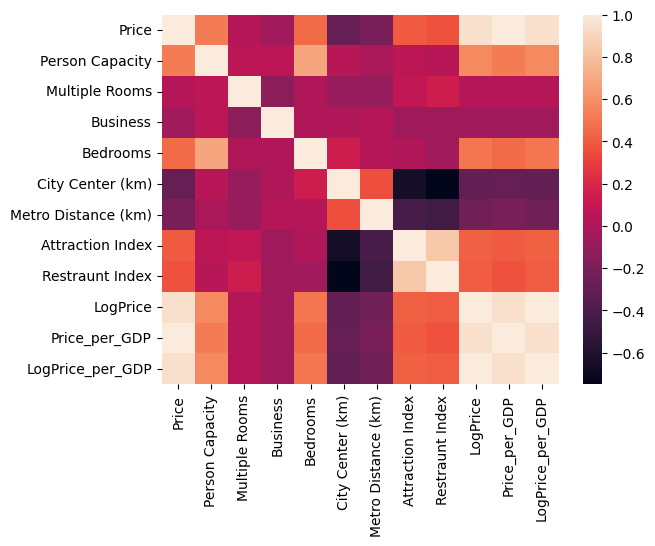

In [17]:
corr = data_entire_homeapt.corr(numeric_only=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [ ]:
corr['LogPrice'].sort_values()

#### Modelo - Lasso

In [18]:
data_entire_homeapt = pd.get_dummies(data_entire_homeapt, columns = ['City','Day','Private Room','Superhost'], drop_first = True)

In [19]:
features = data_entire_homeapt.drop(columns=['Price', 'LogPrice', 'Price_per_GDP', 'LogPrice_per_GDP', 'City_Athens', 'City_Barcelona','City_Berlin','City_Budapest','City_Lisbon','City_Paris','City_Rome','City_Vienna', 'Room Type']).copy()
target = data_entire_homeapt['LogPrice_per_GDP'].copy()

In [20]:
X = features
Y = target

In [21]:
# Dicionário vazio para armazenar os coeficientes
coeficientes_dict = {}

# Itere de 1 a 1001
for random_state in range(1, 1002):
    # Divida os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=random_state)

    # Divida os dados de treinamento em conjuntos de treinamento e validação
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

     # Crie uma instância do modelo de Lasso
    modeloAmsterdam_Lasso01 = Lasso(alpha=0.05)

    # Treine o modelo
    modeloAmsterdam_Lasso01.fit(X_train, y_train)

    # Obtenha os coeficientes
    coeficientes = dict(zip(modeloAmsterdam_Lasso01.feature_names_in_, modeloAmsterdam_Lasso01.coef_))
    
    # Atualize o dicionário de coeficientes
    for feature, coeficiente in coeficientes.items():
        if feature not in coeficientes_dict:
            coeficientes_dict[feature] = []
        coeficientes_dict[feature].append(coeficiente)

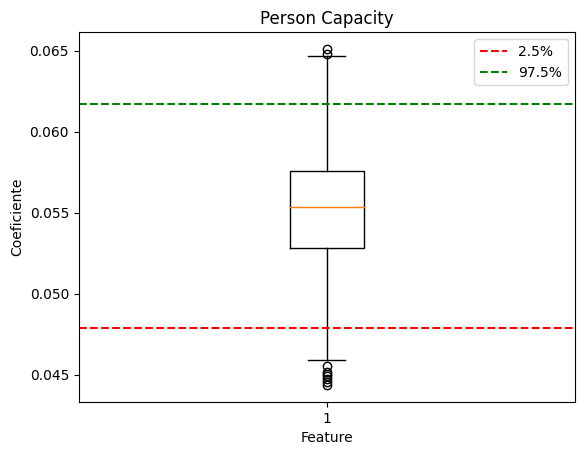

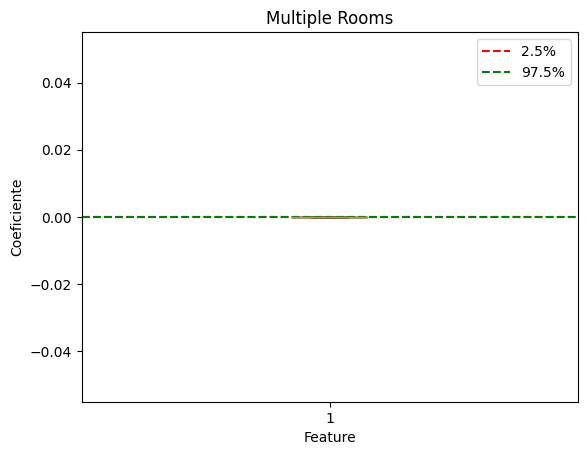

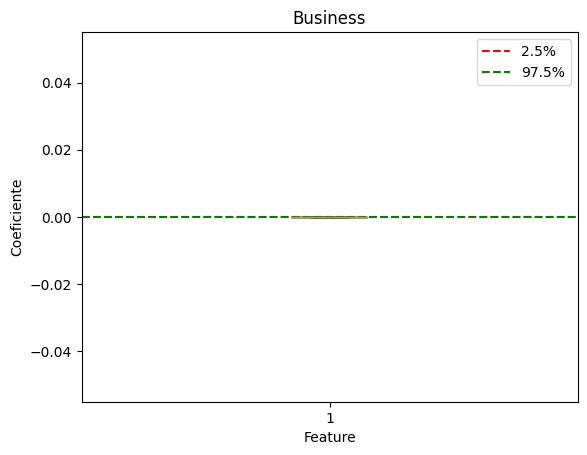

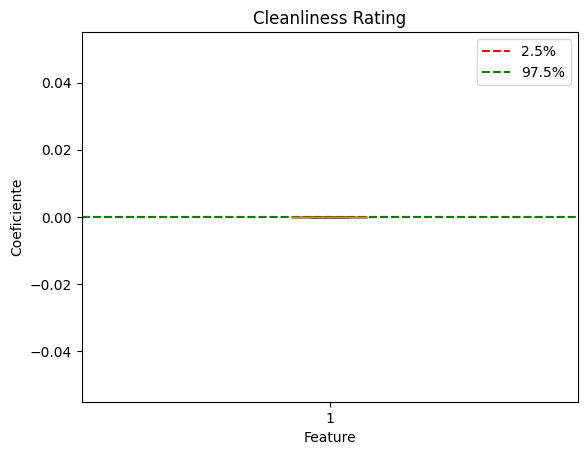

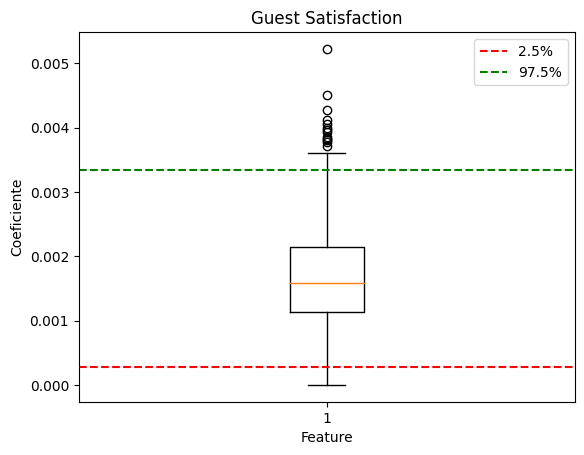

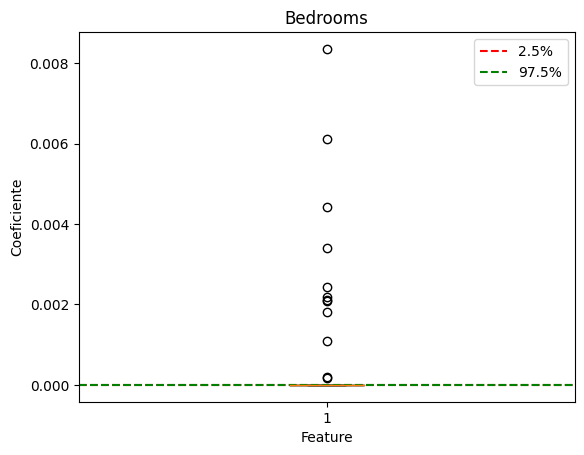

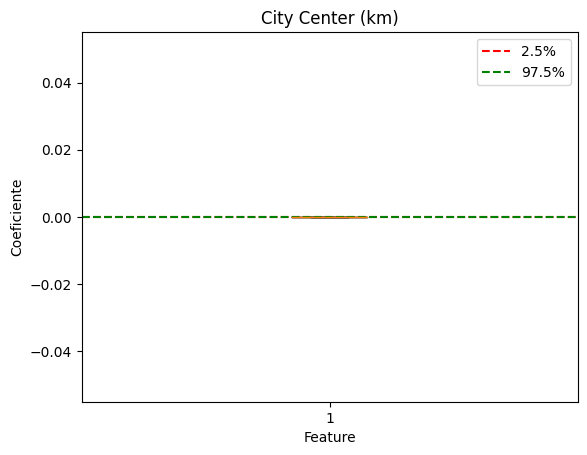

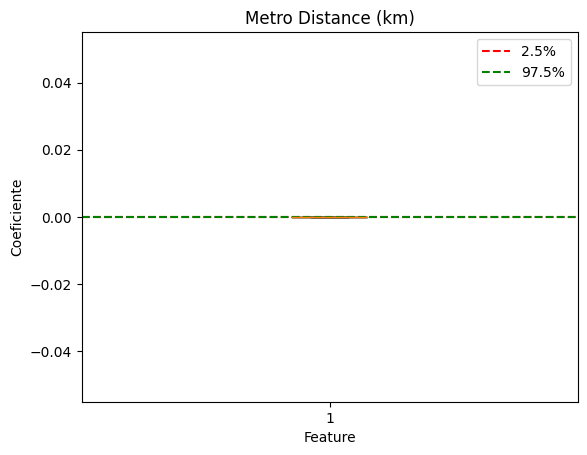

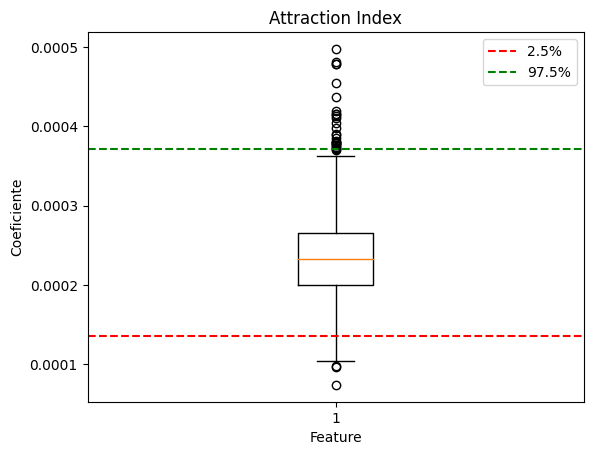

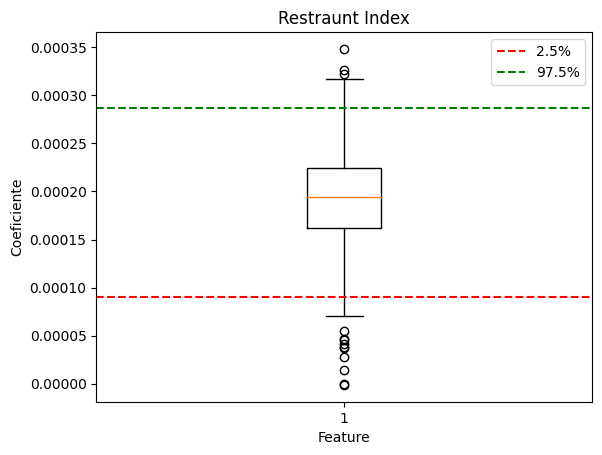

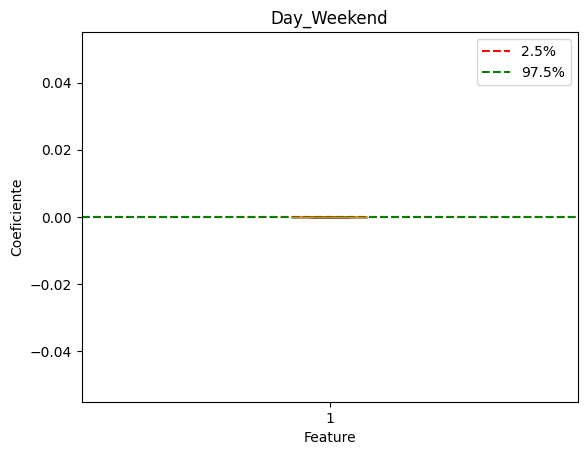

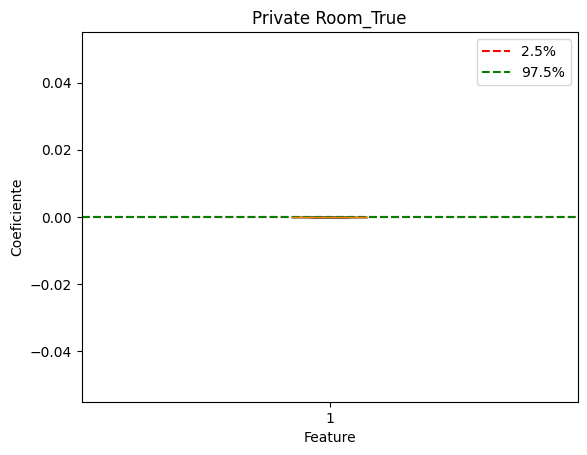

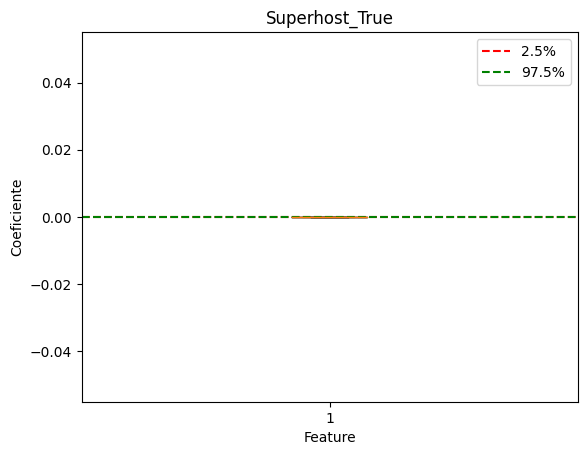

In [22]:
utils.plot_coefModeloLasso(coeficientes_dict)

## Amsterdam Private room

In [23]:
data_private_room = data.loc[data['Room Type'] == 'Private room'].copy()

In [ ]:
corr = data_private_room.corr(numeric_only=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [ ]:
corr['LogPrice'].sort_values()

In [24]:
data_private_room = pd.get_dummies(data_private_room, columns = ['City','Day','Private Room','Superhost'], drop_first = True)

In [25]:
features = data_private_room.drop(columns=['Price', 'LogPrice', 'Price_per_GDP', 'LogPrice_per_GDP', 'City_Athens', 'City_Barcelona','City_Berlin','City_Budapest','City_Lisbon','City_Paris','City_Rome','City_Vienna', 'Room Type']).copy()
target = data_private_room['LogPrice_per_GDP'].copy()

In [26]:
X = features
Y = target

In [27]:
# Dicionário vazio para armazenar os coeficientes
coeficientes_dict = {}

# Itere de 1 a 1001
for random_state in range(1, 1002):
    # Divida os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=random_state)

    # Divida os dados de treinamento em conjuntos de treinamento e validação
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

     # Crie uma instância do modelo de Lasso
    modeloAmsterdam_Lasso01 = Lasso(alpha=0.05)

    # Treine o modelo
    modeloAmsterdam_Lasso01.fit(X_train, y_train)

    # Obtenha os coeficientes
    coeficientes = dict(zip(modeloAmsterdam_Lasso01.feature_names_in_, modeloAmsterdam_Lasso01.coef_))
    
    # Atualize o dicionário de coeficientes
    for feature, coeficiente in coeficientes.items():
        if feature not in coeficientes_dict:
            coeficientes_dict[feature] = []
        coeficientes_dict[feature].append(coeficiente)

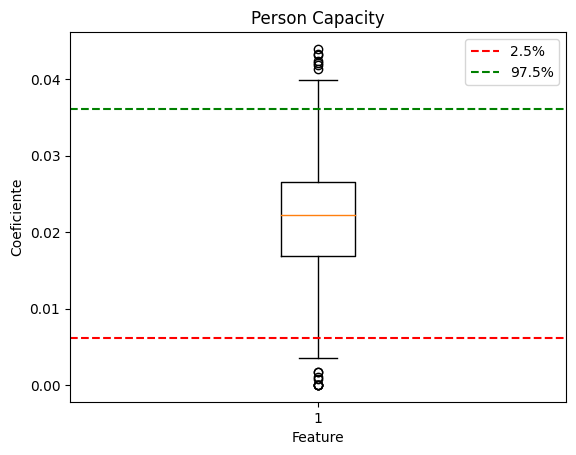

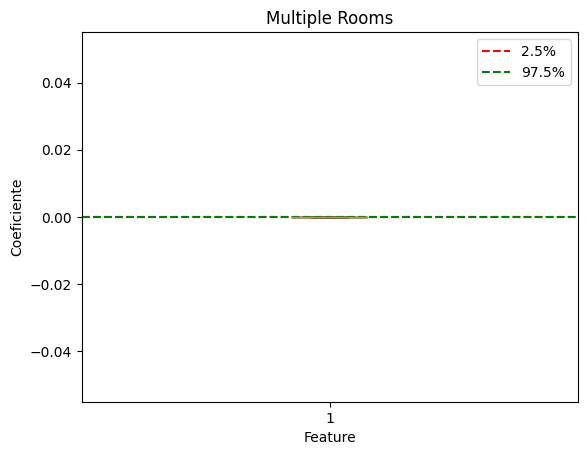

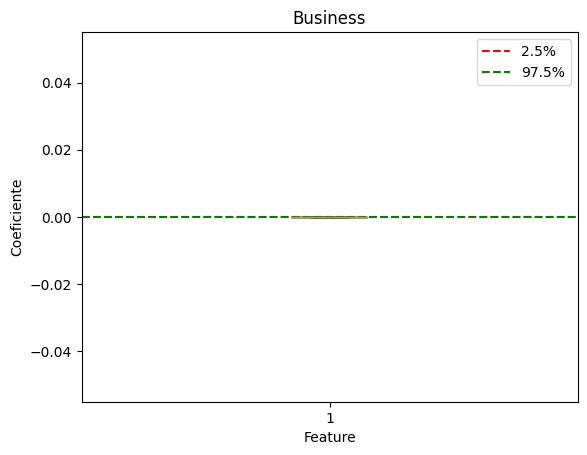

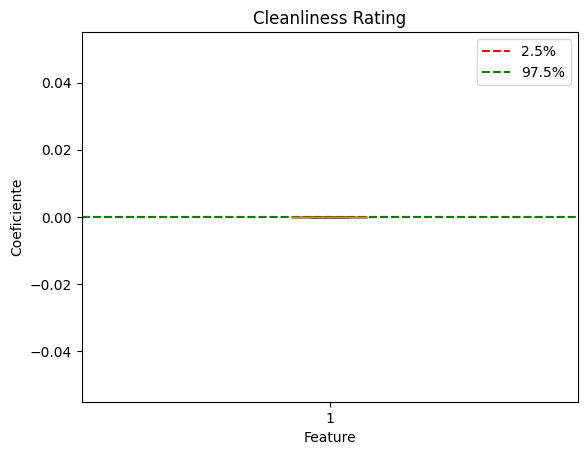

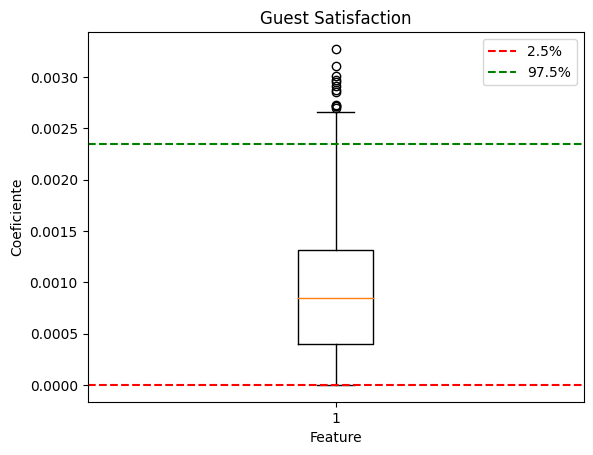

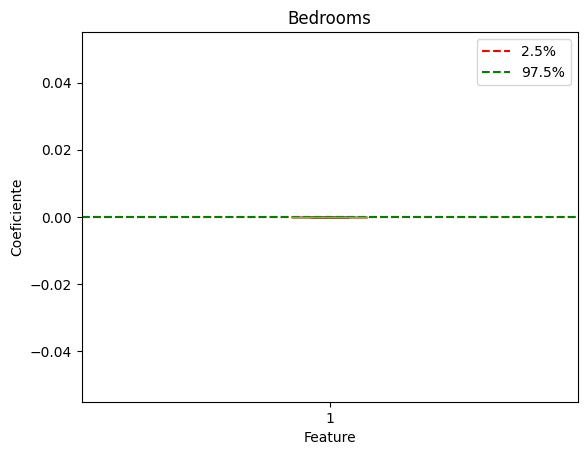

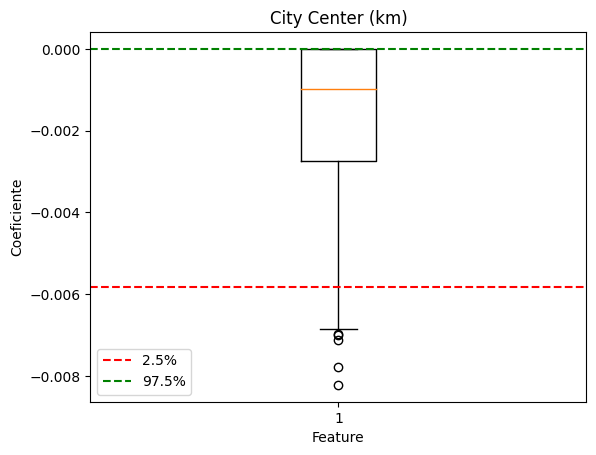

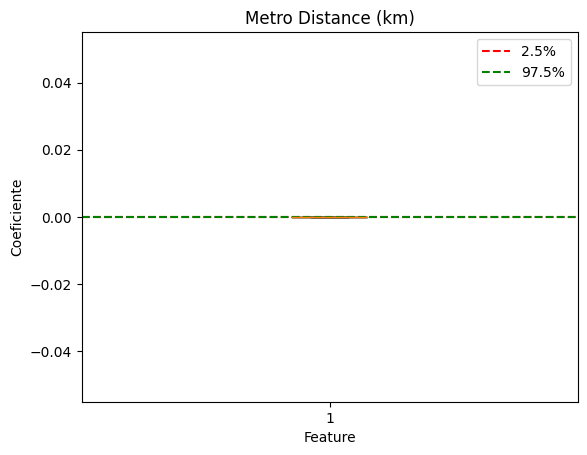

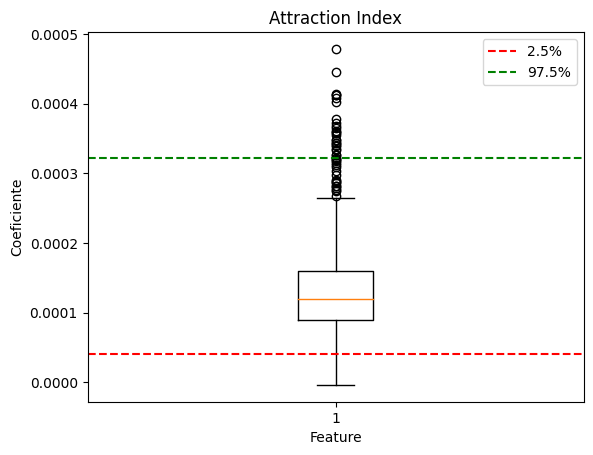

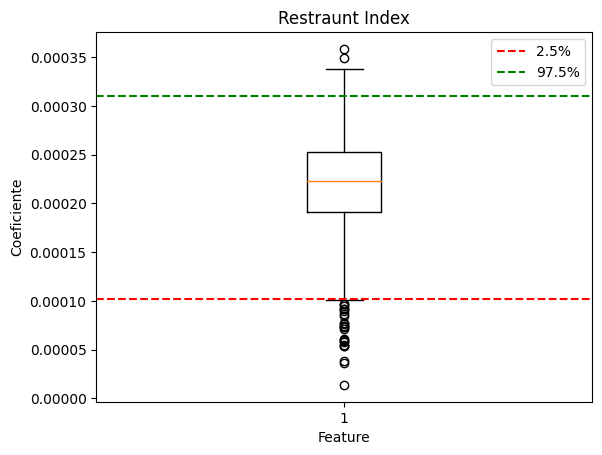

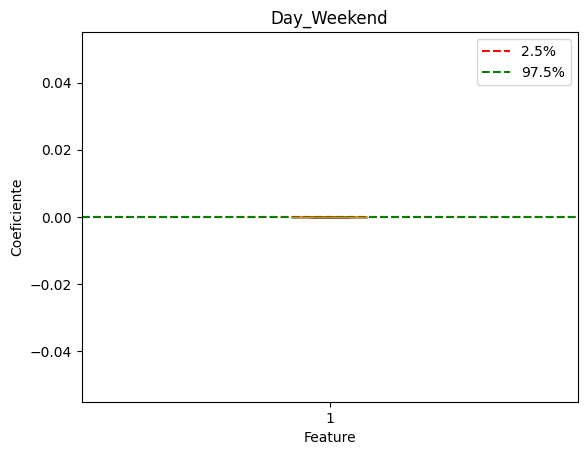

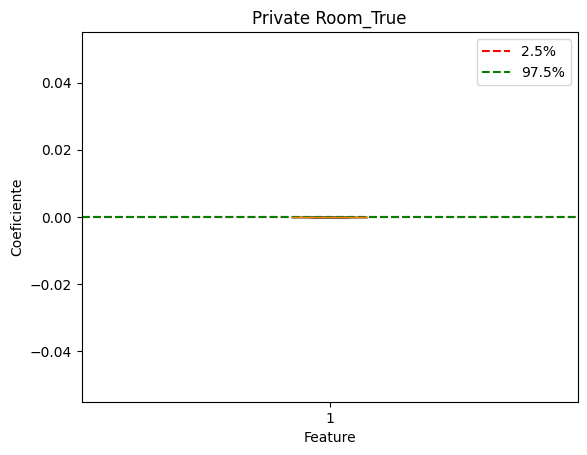

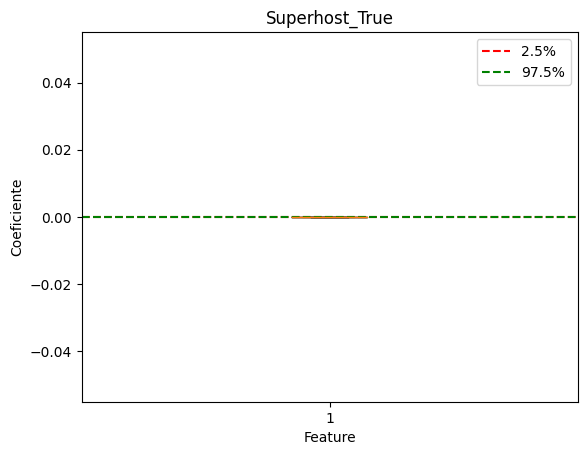

In [28]:
utils.plot_coefModeloLasso(coeficientes_dict)